In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义生成器网络
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


# 定义判别器网络
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

Epoch [0/100], Step [0/938], Gen Loss: 0.6904, Disc Loss: 1.4384
Epoch [0/100], Step [100/938], Gen Loss: 4.4248, Disc Loss: 0.2543
Epoch [0/100], Step [200/938], Gen Loss: 5.1426, Disc Loss: 0.3678
Epoch [0/100], Step [300/938], Gen Loss: 5.4174, Disc Loss: 0.0201
Epoch [0/100], Step [400/938], Gen Loss: 6.4322, Disc Loss: 0.1162
Epoch [0/100], Step [500/938], Gen Loss: 10.3771, Disc Loss: 0.0435
Epoch [0/100], Step [600/938], Gen Loss: 5.0909, Disc Loss: 0.1356
Epoch [0/100], Step [700/938], Gen Loss: 8.2581, Disc Loss: 0.1008
Epoch [0/100], Step [800/938], Gen Loss: 7.1289, Disc Loss: 0.1405
Epoch [0/100], Step [900/938], Gen Loss: 7.2015, Disc Loss: 0.1527
Epoch [1/100], Step [0/938], Gen Loss: 7.3112, Disc Loss: 0.0708
Epoch [1/100], Step [100/938], Gen Loss: 7.6759, Disc Loss: 0.1676
Epoch [1/100], Step [200/938], Gen Loss: 7.5993, Disc Loss: 0.2566
Epoch [1/100], Step [300/938], Gen Loss: 5.3079, Disc Loss: 0.2572
Epoch [1/100], Step [400/938], Gen Loss: 7.2662, Disc Loss: 0.594

In [ ]:
# 定义参数
latent_dim = 100
img_shape = 28 * 28
lr = 0.0002
batch_size = 64
epochs = 100

# 加载数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 初始化生成器和判别器
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# 定义优化器和损失函数
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# 训练网络
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # 初始化真假标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 将图像展平
        imgs = imgs.view(batch_size, -1).to(device)

        # 训练判别器
        optimizer_D.zero_grad()

        # 真实图像损失
        real_outputs = discriminator(imgs)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # 生成假图像并计算假图像损失
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        # 更新判别器参数
        optimizer_D.step()

        # 训练生成器
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        outputs = discriminator(gen_imgs)
        gen_loss = criterion(outputs, real_labels)
        gen_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}], "
                f"Step [{i}/{len(train_loader)}], "
                f"Gen Loss: {gen_loss.item():.4f}, "
                f"Disc Loss: {(real_loss + fake_loss).item():.4f}"
            )

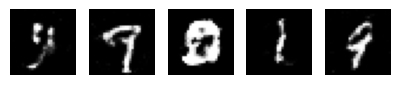

In [6]:
# 测试生成器
def test_generator(generator, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_imgs = generator(z)
    generated_imgs = generated_imgs.view(num_samples, 28, 28)
    return generated_imgs


# 显示生成的图像
def show_generated_images(generated_imgs):
    plt.figure(figsize=(10, 2))
    for i in range(generated_imgs.size(0)):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_imgs[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()


# 生成图像并显示
num_samples = 5
generated_imgs = test_generator(generator, num_samples)
show_generated_images(generated_imgs)
